# Modelo de Regresión Logística para Detección de Intrusos en la Red

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [88]:
# Cargar los datos
df = pd.read_excel("Tabla_Intruso_Detectado.xlsx")
df.head()

,ID,FLAG_INTRUSO_DETECTADO,FLAG_IP_EXTRANJERA,MINUTOS_CONEXION,N_CONEXION_U3M
0,1,0,1,13,11
1,2,0,0,14,9
2,3,0,0,10,13
3,4,0,0,9,7
4,5,0,0,10,11


### Definiendo la variable objetivo y las variables predictoras

El objetivo es predecir si se detecta un intruso (FLAG_INTRUSO_DETECTADO, variable binaria), en función de:
- Si la IP es extranjera (FLAG_IP_EXTRANJERA)
- Minutos de conexión (MINUTOS_CONEXION)
- Número de conexiones a la red U3M (N_CONEXION_U3M)

In [89]:
# Definir X (predictoras) e y (objetivo)
X = df[['FLAG_IP_EXTRANJERA', 'MINUTOS_CONEXION', 'N_CONEXION_U3M']]
y = df['FLAG_INTRUSO_DETECTADO']

### Análisis exploratorio preliminar

In [90]:
df.describe()

,ID,FLAG_INTRUSO_DETECTADO,FLAG_IP_EXTRANJERA,MINUTOS_CONEXION,N_CONEXION_U3M
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.00000
mean,5000.50000,0.30000,0.400000,10.800000,10.43000
std,2886.89568,0.45828,0.489922,2.441433,5.15051
min,1.00000,0.00000,0.000000,7.000000,0.00000
25%,2500.75000,0.00000,0.000000,8.750000,6.00000
50%,5000.50000,0.00000,0.000000,11.000000,11.00000
75%,7500.25000,1.00000,1.000000,12.250000,14.00000
max,10000.00000,1.00000,1.000000,15.000000,20.00000


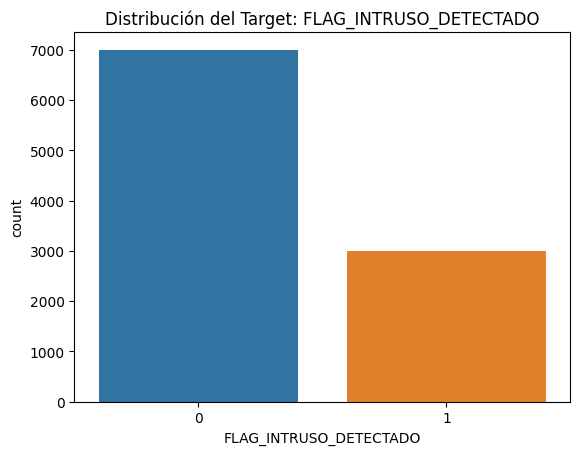

In [91]:
# Ver distribución de la variable objetivo
sns.countplot(x=y)
plt.title("Distribución del Target: FLAG_INTRUSO_DETECTADO")
plt.show()

El gráfico muestra la distribución de la variable objetivo FLAG_INTRUSO_DETECTADO, que indica si se ha detectado un intruso (1) o no (0).
- Aproximadamente el 70% de las observaciones corresponden a casos donde no se detectó un intruso.
- El restante 30% corresponde a casos donde sí se detectó un intruso.

Esto sugiere una ligera desbalanceo en la variable de respuesta, aunque no es extremo. 

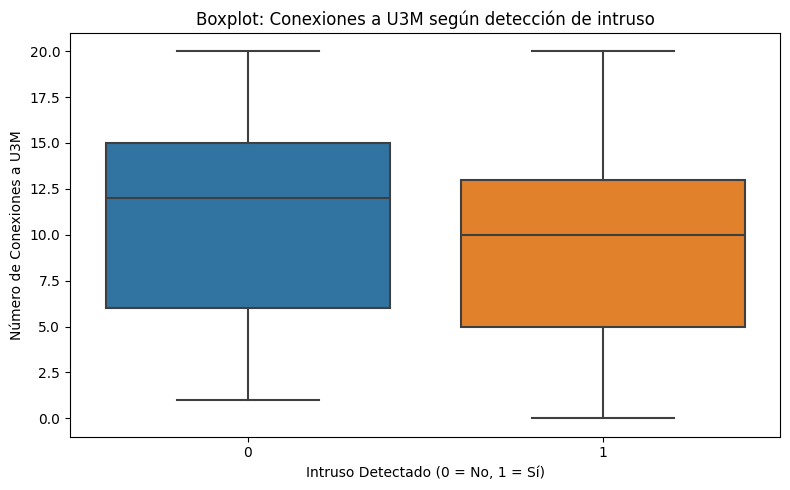

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot de N_CONEXION_U3M por FLAG_INTRUSO_DETECTADO
plt.figure(figsize=(8, 5))
sns.boxplot(x='FLAG_INTRUSO_DETECTADO', y='N_CONEXION_U3M', data=df)
plt.title("Boxplot: Conexiones a U3M según detección de intruso")
plt.xlabel("Intruso Detectado (0 = No, 1 = Sí)")
plt.ylabel("Número de Conexiones a U3M")
plt.tight_layout()
plt.show()

A mayor número de conexiones a la red U3M, parece menos probable que se trate de un intruso.

**Mediana:**
- Los no intrusos (0) tienen una mediana de conexiones mayor (~12).
- Los intrusos (1) tienen una mediana menor (~10).

**Rango intercuartílico (IQR):**
- Ambos grupos comparten un rango similar (aproximadamente entre 5 y 15), pero los no intrusos presentan una mayor concentración en los valores altos.

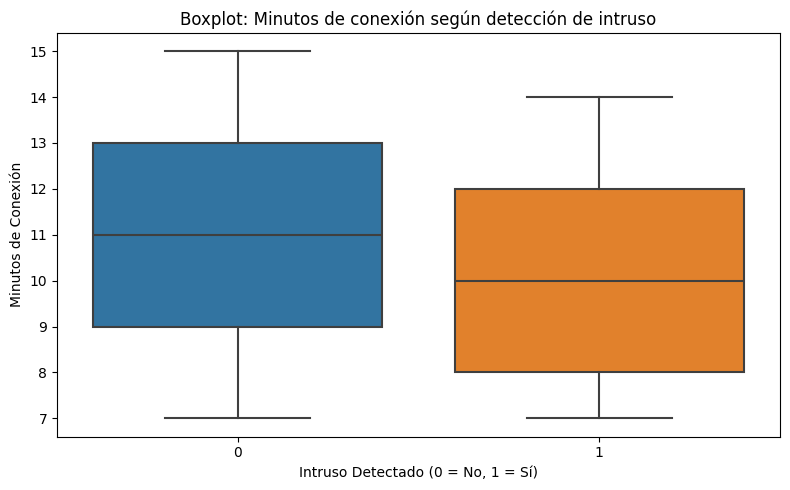

In [93]:
# Boxplot de MINUTOS_CONEXION por FLAG_INTRUSO_DETECTADO
plt.figure(figsize=(8, 5))
sns.boxplot(x='FLAG_INTRUSO_DETECTADO', y='MINUTOS_CONEXION', data=df)
plt.title("Boxplot: Minutos de conexión según detección de intruso")
plt.xlabel("Intruso Detectado (0 = No, 1 = Sí)")
plt.ylabel("Minutos de Conexión")
plt.tight_layout()
plt.show()

Los usuarios identificados como intrusos tienden a tener sesiones de conexión más cortas que los usuarios regulares.

**Mediana:**
- Los no intrusos (0) tienen una mediana más alta, cerca de 11 minutos.
- Los intrusos (1) tienen una mediana de conexión cercana a 10 minutos.

**Rango intercuartílico (IQR):**
- Los no intrusos tienden a conectarse entre ~9 y ~13 minutos.
- Los intrusos se conectan entre ~8 y ~12 minutos.

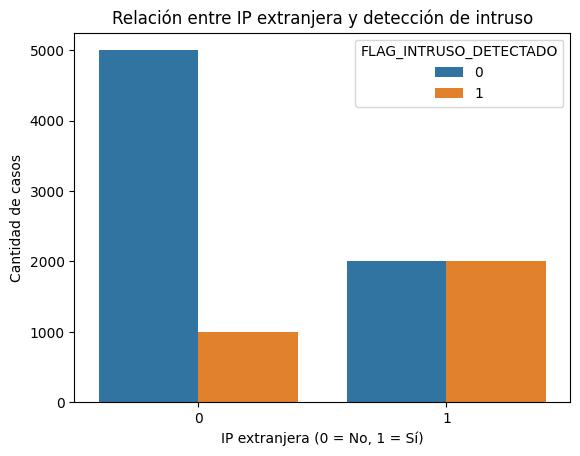

In [94]:
sns.countplot(x='FLAG_IP_EXTRANJERA', hue='FLAG_INTRUSO_DETECTADO', data=df)
plt.title("Relación entre IP extranjera y detección de intruso")
plt.xlabel("IP extranjera (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de casos")
plt.show()

Tener una IP extranjera incrementa notablemente la probabilidad de ser clasificado como intruso.

**Casos con IP nacional (FLAG_IP_EXTRANJERA = 0):**
- La mayoría no fueron intrusos (~5000 casos).
- Un grupo menor (~1000 casos) sí fue detectado como intruso.

**Casos con IP extranjera (FLAG_IP_EXTRANJERA = 1):**
- La distribución se divide prácticamente en partes iguales (~2000 no intrusos vs ~2000 intrusos).

## Preprocesamiento de datos

In [95]:
from sklearn.preprocessing import StandardScaler

# Selección de variables
X = df[['FLAG_IP_EXTRANJERA', 'MINUTOS_CONEXION', 'N_CONEXION_U3M']]
y = df['FLAG_INTRUSO_DETECTADO']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [96]:
scaler = StandardScaler()
cols_to_scale = ['MINUTOS_CONEXION', 'N_CONEXION_U3M']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

## Entrenamiento del modelo logístico 

In [97]:
from sklearn.linear_model import LogisticRegression

In [ ]:
modelo = LogisticRegression(
    solver='liblinear', 
    random_state=42, 
    class_weight='balanced', 
    max_iter=1000
)
modelo.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

### Evaluación del modelo

In [99]:
y_pred = modelo.predict(X_test_scaled)

In [100]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.8803    0.7071    0.7843      2100
           1     0.5316    0.7756    0.6308       900

    accuracy                         0.7277      3000
   macro avg     0.7059    0.7413    0.7075      3000
weighted avg     0.7757    0.7277    0.7382      3000



In [101]:
from sklearn.metrics import precision_recall_curve

# Calcular probas
y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]

# Calcular curvas de precisión y recall según el umbral
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular F1 para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Encontrar el mejor umbral
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Mejor umbral: {best_threshold:.4f} con F1-score: {best_f1:.4f}")

Mejor umbral: 0.5008 con F1-score: 0.6308


In [102]:
y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Reporte de Clasificación (umbral = 0.5008482173367427):
              precision    recall  f1-score   support

           0     0.8803    0.7071    0.7843      2100
           1     0.5316    0.7756    0.6308       900

    accuracy                         0.7277      3000
   macro avg     0.7059    0.7413    0.7075      3000
weighted avg     0.7757    0.7277    0.7382      3000



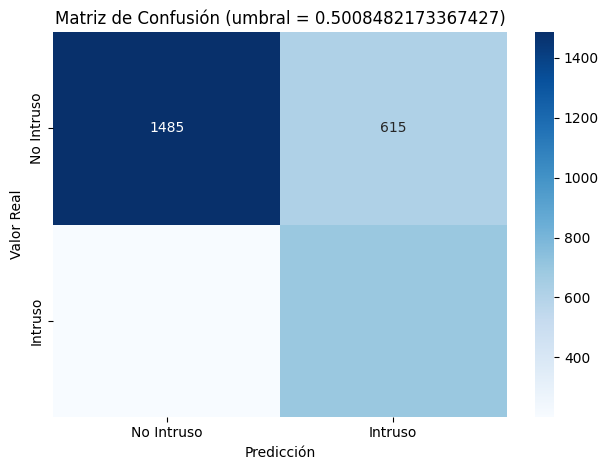

In [103]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Reporte de Clasificación (umbral = {best_threshold}):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Intruso', 'Intruso'],
            yticklabels=['No Intruso', 'Intruso'])
plt.title(f"Matriz de Confusión (umbral = {best_threshold})")
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

In [104]:
for threshold in [0.5, 0.4, 0.35, 0.3, 0.25]:
    y_pred_umbral = (y_pred_proba >= threshold).astype(int)
    print(f"\n--- Umbral: {threshold} ---")
    print(classification_report(y_test, y_pred_umbral, digits=4))


--- Umbral: 0.5 ---
              precision    recall  f1-score   support

           0     0.8803    0.7071    0.7843      2100
           1     0.5316    0.7756    0.6308       900

    accuracy                         0.7277      3000
   macro avg     0.7059    0.7413    0.7075      3000
weighted avg     0.7757    0.7277    0.7382      3000


--- Umbral: 0.4 ---
              precision    recall  f1-score   support

           0     0.8585    0.4852    0.6200      2100
           1     0.4038    0.8133    0.5396       900

    accuracy                         0.5837      3000
   macro avg     0.6311    0.6493    0.5798      3000
weighted avg     0.7221    0.5837    0.5959      3000


--- Umbral: 0.35 ---
              precision    recall  f1-score   support

           0     0.8267    0.3248    0.4663      2100
           1     0.3480    0.8411    0.4924       900

    accuracy                         0.4797      3000
   macro avg     0.5874    0.5829    0.4793      3000
weighted a

In [105]:
print("Intrusos reales en test:", sum(y_test == 1))
print("Total casos en test:", len(y_test))

Intrusos reales en test: 900
Total casos en test: 3000


In [106]:
# Mostrar algunas probabilidades generadas por el modelo
import pandas as pd

probas = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1
df_pred = pd.DataFrame({
    'y_real': y_test.values,
    'proba_intruso': probas
})

# Ver los casos donde el valor real es 1
df_intrusos = df_pred[df_pred['y_real'] == 1]

# Mostrar los percentiles de probabilidad
print("Percentiles de probabilidad para intrusos reales:")
print(df_intrusos['proba_intruso'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

Percentiles de probabilidad para intrusos reales:
count    900.000000
mean       0.003420
std        0.004107
min        0.000056
25%        0.000479
50%        0.002119
75%        0.004649
90%        0.009921
95%        0.011722
max        0.017835
Name: proba_intruso, dtype: float64


In [107]:
# Mostrar los coeficientes beta
coeficientes = modelo.coef_[0]
variables = X_train_scaled.columns
for var, beta in zip(variables, coeficientes):
    print(f"{var}: β = {beta:.4f}")

FLAG_IP_EXTRANJERA: β = 1.1596
MINUTOS_CONEXION: β = -0.4259
N_CONEXION_U3M: β = -0.2572



Importancia relativa de las variables (según |β|):
             Variable      Beta  Importancia_Abs
0  FLAG_IP_EXTRANJERA  1.159633         1.159633
1    MINUTOS_CONEXION -0.425901         0.425901
2      N_CONEXION_U3M -0.257218         0.257218


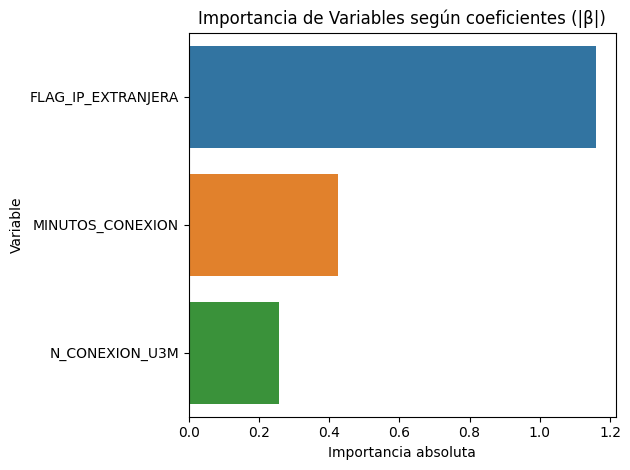

In [108]:
importancia = pd.DataFrame({
    'Variable': variables,
    'Beta': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values(by='Importancia_Abs', ascending=False)

print("\nImportancia relativa de las variables (según |β|):")
print(importancia)

# Gráfico de importancia
sns.barplot(x='Importancia_Abs', y='Variable', data=importancia)
plt.title("Importancia de Variables según coeficientes (|β|)")
plt.xlabel("Importancia absoluta")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

In [109]:
from sklearn.metrics import log_loss

# Pseudo R² de McFadden
ll_full = -log_loss(y_test, y_pred_proba, normalize=False)
ll_null = -log_loss(y_test, np.full_like(y_test, y.mean()), normalize=False)

pseudo_r2 = 1 - (ll_full / ll_null)
print(f"\nPseudo-R² de McFadden: {pseudo_r2:.4f}")


Pseudo-R² de McFadden: 0.9438


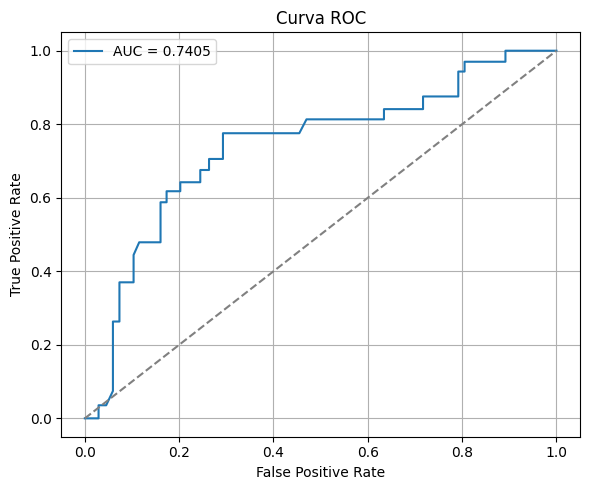

In [110]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular valores para la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Graficar
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # línea aleatoria
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

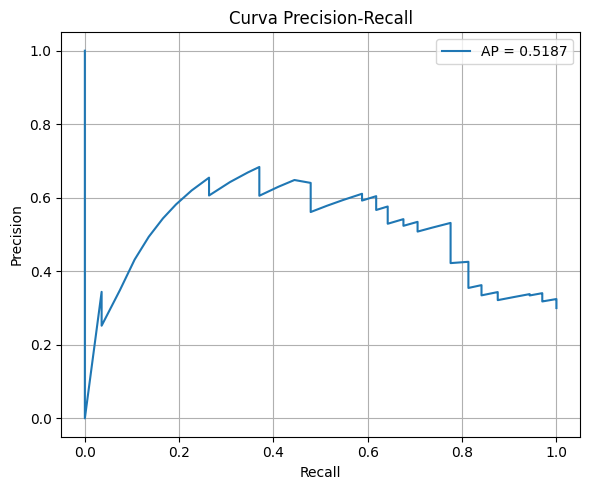

In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular precision, recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Graficar
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=5)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [113]:
modelo_final = LogisticRegression(
    C=0.01,
    class_weight='balanced',
    penalty='l2',
    solver='liblinear'
)
modelo_final.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

In [114]:
for var, coef in zip(X_train.columns, modelo_final.coef_[0]):
    print(f"{var}: β = {coef:.4f}")

FLAG_IP_EXTRANJERA: β = 1.1596
MINUTOS_CONEXION: β = -0.4259
N_CONEXION_U3M: β = -0.2572
